# Suplemental plots

Plots to accompany approval request. These plots where suggested by Seckel, Cosmin and Nick

### Jan 21, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara
import matplotlib.colors as colors


Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18

# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events

In [27]:
SNR_cut = 5
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noiseOn/window_Sol0/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noise")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noiseOn/window_Sol0/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data) 
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[abs(recoNu.maxV)>1]
recoNu = recoNu.loc[abs(recoNu.maxV)<1450]
recoNu = recoNu.loc[abs(recoNu.maxH)>1]
recoNu = recoNu.loc[abs(recoNu.maxH)<1450]
recoNu = recoNu.loc[recoNu.theta_reco>=np.pi/2]
# recoNu = recoNu.loc[recoNu.weight>1E-100]
recoNu["SNR_V"] = abs(recoNu.maxV)/recoNu.rmsV
recoNu["SNR_H"] = abs(recoNu.maxH)/recoNu.rmsH
# recoNu = recoNu.loc[abs(recoNu.SNR_H-5)<1]
recoNu = recoNu.loc[(recoNu.SNR_H>=SNR_cut) & (recoNu.SNR_V>=SNR_cut)]
# recoNu = recoNu.loc[recoNu.SNR_V>=5]
print(len(recoNu))
recoNu.batch = recoNu.batch.astype(int)

array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    if(i.powerH==0 or i.powerV==0):
        R_Reco.append(np.nan)
        R_True.append(np.nan)
        array2.append(np.nan)
        dot.append(np.nan)
        continue
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
#     R_Reco.append(abs(i.peak_H/i.peak_V))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    PolReco = util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R))
    array2.append(PolReco)
#     array2.append(util.PolVectorReco_debug(i.peak_V,i.peak_H, i.theta_reco, i.phi_reco,np.sign(R)))

    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(i.PolTrue,PolReco))
recoNu["PolReco2"] = array2
# recoNu["PolReco2"] = util.PolVectorReco(recoNu.maxV, recoNu.maxH, recoNu.theta_reco,recoNu.phi_reco)

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot
# recoNu = recoNu.loc[abs(recoNu.dotProd)<1E-2]
recoNu = recoNu.dropna()

# recoNu = recoNu.loc[abs(np.degrees(recoNu.view_ang)-56.037)<5]


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


thetaPol_true = np.degrees(np.arccos(abs(Pz_true)))
thetaPol_reco = np.degrees(np.arccos(abs(Pz_reco)))
phiPol_true = np.degrees(np.arctan2(abs(Py_true),abs(Px_true)))
phiPol_reco = np.degrees(np.arctan2(abs(Py_reco),abs(Px_reco)))


recoNu["delta"] = thetaPol_reco-thetaPol_true
recoNu["thetaPol_reco"] = thetaPol_reco
recoNu["thetaPol_true"] = thetaPol_true

recoNu["deltaPhi"] = phiPol_reco-phiPol_true
recoNu["phiPol_reco"] = phiPol_reco
recoNu["phiPol_true"] = phiPol_true

# delta = thetaPol_reco-thetaPol_true
# deltaPhi = phiPol_reco-phiPol_true
recoNu = recoNu.dropna()
# delta = delta[~np.isnan(delta)]


38619


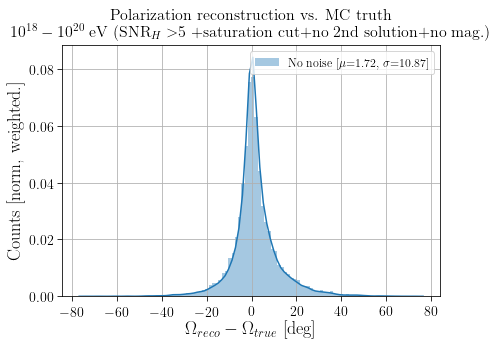

In [28]:
delta = recoNu["delta"]
plt.figure(figsize=(7,5))
delta_mean= np.ma.average(delta,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (delta - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)

sns.distplot(delta, bins=100,hist_kws={'weights': recoNu.weight},norm_hist=False,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{20}$ eV (SNR$_{H}>$5 +saturation cut+no 2nd solution+no mag.)", fontsize=16)
# plt.xlim(-20,20)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_noNoiseOmega.png', dpi=250)


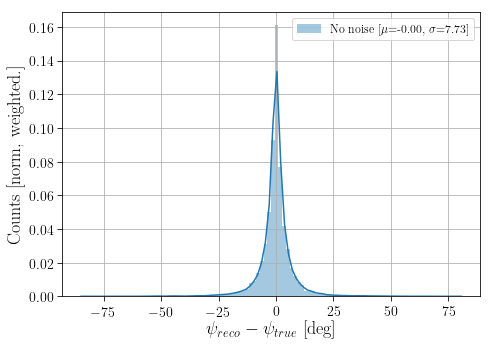

In [29]:
plt.figure(figsize=(7,5))
deltaPhi = recoNu["deltaPhi"]
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_mean = np.ma.average(deltaPhi,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (deltaPhi - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)
sns.distplot(deltaPhi, hist_kws={'weights': recoNu.weight},bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{20}$ eV (SNR$_{H}>$5 +saturation cut+no 2nd solution+no mag.)", fontsize=16)
# plt.xlim(-20,20)

# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_noNoisePsi.png', dpi=250)


## $\Omega$

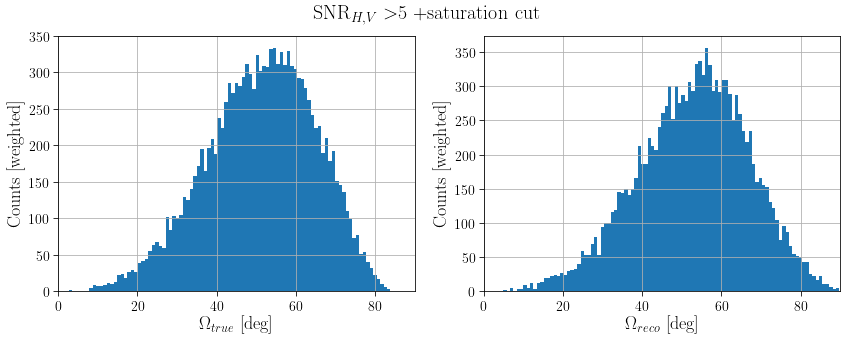

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].hist(recoNu["thetaPol_true"], bins = 100, weights=recoNu.weight);
ax[0].set_xlabel("$\\Omega_{true}$ [deg]")
ax[0].set_ylabel("Counts [weighted]")
ax[0].set_xlim(0,90)
# ax[0].ylim(0,90)
ax[0].grid()

ax[1].hist(recoNu["thetaPol_reco"], bins = 100, weights=recoNu.weight);
ax[1].set_xlabel("$\\Omega_{reco}$ [deg]")
ax[1].set_ylabel("Counts [weighted]")
ax[1].set_xlim(0,90)
# ax[0].set_yscale('log')
ax[1].grid()
plt.suptitle("SNR$_{H,V}>$%i +saturation cut"%SNR_cut, fontsize=20)
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{20}$ eV (SNR$_{H}>$5 +saturation cut+no 2nd solution+no mag.)", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/PolReco_finalPlots/OmegaDistribution.png', dpi=250)

### $\Omega_{true}$ vs. $\Delta \Omega$

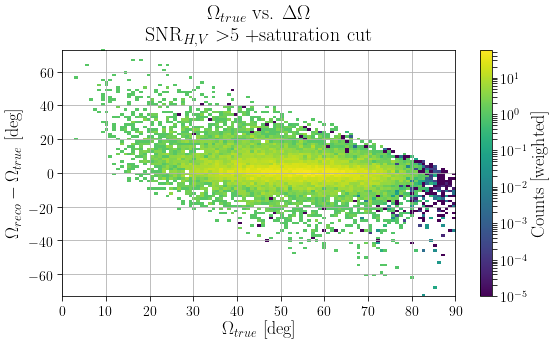

In [31]:
plt.figure(figsize=(8,5))

plt.hist2d(recoNu["thetaPol_true"],recoNu["delta"], bins = 100,norm=colors.LogNorm(vmin = 1E-5), weights=recoNu.weight);
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\Omega_{true}$ [deg]")
plt.ylabel("$\\Omega_{reco}-\\Omega_{true}$ [deg]")
plt.title("$\Omega_{true}$ vs. $\Delta \Omega$ \n SNR$_{H,V}>$%i +saturation cut"%SNR_cut)
plt.xlim(0,90)
# plt.ylim(0,100)
# plt.xticks(np.arange(0,100,10))
# plt.yticks(np.arange(-360,360,60))
plt.grid()
# plt.plot(x,y,"--", c = "red", alpha = 0.3, label = "$y=x$")
# plt.legend()
plt.tight_layout()
plt.savefig(my_path_plots+'/PolReco_finalPlots/OmegaTrueVsDeltaOmega.png', dpi=250)

### $\Omega_{true}$ vs. $\Omega_{reco}$

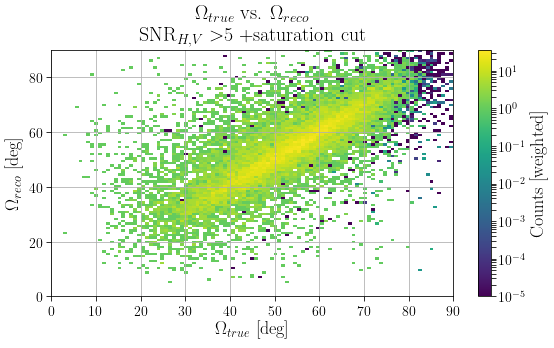

In [32]:
plt.figure(figsize=(8,5))

plt.hist2d(recoNu["thetaPol_true"],recoNu["thetaPol_reco"], bins = 100,norm=colors.LogNorm(vmin = 1E-5), weights=recoNu.weight);
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\Omega_{true}$ [deg]")
plt.ylabel("$\\Omega_{reco}$ [deg]")
plt.title("$\Omega_{true}$ vs. $\Omega_{reco}$\n SNR$_{H,V}>$%i +saturation cut"%SNR_cut)
plt.xlim(0,90)
plt.ylim(0,90)
plt.grid()

plt.tight_layout()
plt.savefig(my_path_plots+'/PolReco_finalPlots/OmegaTrueVsOmegaReco.png', dpi=250)



## $\Psi$

## Distribution of $\Psi$

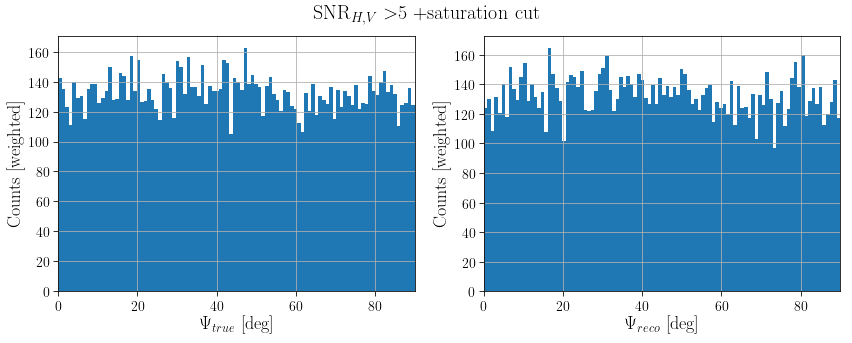

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].hist(recoNu["phiPol_true"], bins = 100, weights=recoNu.weight);
ax[0].set_xlabel("$\\Psi_{true}$ [deg]")
ax[0].set_ylabel("Counts [weighted]")
ax[0].set_xlim(0,90)
# ax[0].ylim(0,90)
ax[0].grid()

ax[1].hist(recoNu["phiPol_reco"], bins = 100, weights=recoNu.weight);
ax[1].set_xlabel("$\\Psi_{reco}$ [deg]")
ax[1].set_ylabel("Counts [weighted]")
ax[1].set_xlim(0,90)
# ax[0].set_yscale('log')
ax[1].grid()
plt.suptitle("SNR$_{H,V}>$%i +saturation cut"%SNR_cut, fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/PolReco_finalPlots/PsiDistribution.png', dpi=250)

### $\Psi_{true}$ vs. $\Psi_{reco}$

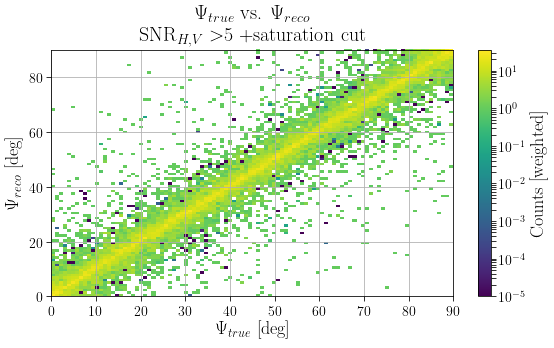

In [34]:
plt.figure(figsize=(8,5))

plt.hist2d(recoNu["phiPol_true"],recoNu["phiPol_reco"], bins = 100,norm=colors.LogNorm(vmin = 1E-5), weights=recoNu.weight);
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\Psi_{true}$ [deg]")
plt.ylabel("$\\Psi_{reco}$ [deg]")
plt.title("$\Psi_{true}$ vs. $\Psi_{reco}$ \n SNR$_{H,V}>$%i +saturation cut"%SNR_cut)
plt.xlim(0,90)
plt.ylim(0,90)
plt.grid()

plt.tight_layout()
plt.savefig(my_path_plots+'/PolReco_finalPlots/PsiTrueVsPsiReco.png', dpi=250)


### $\Psi_{true}$ vs. $\Delta \Psi$

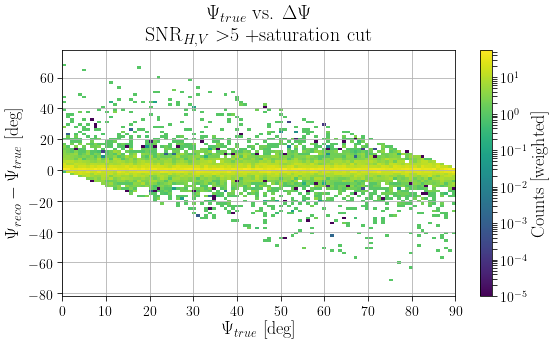

In [35]:
plt.figure(figsize=(8,5))

plt.hist2d(recoNu["phiPol_true"],recoNu["deltaPhi"], bins = 100,norm=colors.LogNorm(vmin = 1E-5), weights=recoNu.weight);
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\Psi_{true}$ [deg]")
plt.ylabel("$\\Psi_{reco}-\\Psi_{true}$ [deg]")
plt.title("$\Psi_{true}$ vs. $\Delta \Psi$ \n SNR$_{H,V}>$%i +saturation cut"%SNR_cut)
plt.xlim(0,90)
# plt.ylim(0,100)
# plt.xticks(np.arange(0,100,10))
# plt.yticks(np.arange(-360,360,60))
plt.grid()
# plt.plot(x,y,"--", c = "red", alpha = 0.3, label = "$y=x$")
# plt.legend()
plt.tight_layout()
plt.savefig(my_path_plots+'/PolReco_finalPlots/PsiTrueVsDeltaPsi.png', dpi=250)

## Resolution as a function of neutrino energy

In [12]:
from scipy.optimize import curve_fit

# scipy.stats.norm.fit(delta)
def gauss(x,A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
bins=100


In [13]:
mean = [[],[],[]]
mean_err = [[],[]]
resolution = [[],[],[]]
resolution_err = [[],[],[]]
meanH = [[],[],[]]
meanH_err = [[],[]]
resolutionH = [[],[],[]]
resolutionH_err = [[],[],[]]
for energy in np.arange(17,21,0.5):
    SNR_recoNu = recoNu.loc[recoNu.energyArr==energy]

    delta = SNR_recoNu.delta
    deltaPhi = SNR_recoNu.deltaPhi
    delta_mean = np.ma.median(delta)
    variance = np.dot(SNR_recoNu.weight, (delta - delta_mean) ** 2) / SNR_recoNu.weight.sum()
    delta_std = np.sqrt(variance)
    
    data_entries_Om, bins_Om = np.histogram(delta, bins=bins, weights=SNR_recoNu.weight, density=True)
    binscenters_Om = np.array([0.5 * (bins_Om[i] + bins_Om[i+1]) for i in range(len(bins_Om)-1)])
    poptOm, pcov = curve_fit(gauss, xdata=binscenters_Om, ydata=data_entries_Om)
    perr_Om = np.sqrt(np.diag(pcov))   
    mean_err[0].append(perr_Om[1])
    resolution_err[0].append(perr_Om[2])

    data_entries_Psi, bins_Psi = np.histogram(deltaPhi, bins=bins, weights=SNR_recoNu.weight, density=True)
    binscenters_Psi = np.array([0.5 * (bins_Psi[i] + bins_Psi[i+1]) for i in range(len(bins_Psi)-1)])
    poptPsi, pcov = curve_fit(gauss, xdata=binscenters_Psi, ydata=data_entries_Psi)
    perr_Psi = np.sqrt(np.diag(pcov))    
    mean_err[1].append(perr_Psi[1])
    resolution_err[1].append(perr_Psi[2])
    
    deltaPhi_mean = np.ma.median(deltaPhi)
    variancePhi = np.dot(SNR_recoNu.weight, (deltaPhi - deltaPhi_mean) ** 2) / SNR_recoNu.weight.sum()
    deltaPhi_std = np.sqrt(variancePhi)
    
    resolution[0].append(energy)
#     resolution[1].append(delta_std)
#     resolution[2].append(deltaPhi_std)
    resolution[1].append(poptOm[2])
    resolution[2].append(poptPsi[2])
    
    mean[0].append(energy)
#     mean[1].append(delta_mean)
#     mean[2].append(deltaPhi_mean)
    
    mean[1].append(poptOm[1])
    mean[2].append(poptPsi[1])

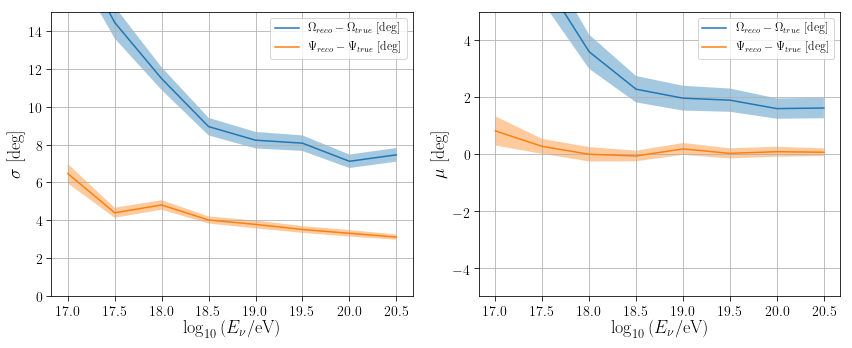

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(resolution[0],resolution[1], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[0].fill_between(resolution[0],resolution[1]+np.array(resolution_err[0]),resolution[1]-np.array(resolution_err[0]),alpha=0.4)
axes[0].plot(resolution[0],resolution[2], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
axes[0].fill_between(resolution[0],resolution[2]+np.array(resolution_err[1]),resolution[2]-np.array(resolution_err[1]),alpha=0.4)
axes[0].set_xlabel("$\log_{10}{(E_{\\nu}}$/eV)")
axes[0].set_ylabel("$\sigma$ [deg]")
axes[0].legend()
axes[0].grid()
axes[0].set_ylim(0,15)


axes[1].plot(mean[0],mean[1], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[1].fill_between(mean[0],mean[1]+np.array(mean_err[0]),mean[1]-np.array(mean_err[0]),alpha=0.4)
axes[1].plot(mean[0],mean[2], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
axes[1].fill_between(mean[0],mean[2]+np.array(mean_err[1]),mean[2]-np.array(mean_err[1]),alpha=0.4)
axes[1].set_xlabel("$\log_{10}{(E_{\\nu}}$/eV)")
axes[1].set_ylabel("$\mu$ [deg]")
axes[1].legend()
axes[1].grid()
axes[1].set_ylim(-5,5)

fig.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/SNR_scan_ratioPowerWindowed_RecoSign.png', dpi=250)

## Space angle difference

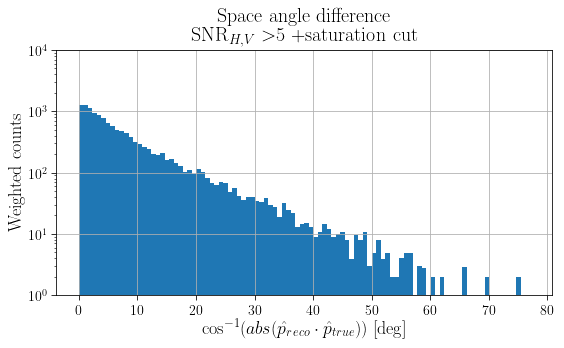

In [39]:
plt.figure(figsize=(8,5))
plt.title("Space angle difference \n SNR$_{H,V}>$%i +saturation cut"%SNR_cut)
disAngle = np.degrees(np.arccos(abs(recoNu.dotProd)))
plt.hist(disAngle, bins = 100, weights=recoNu.weight, density=False);
plt.yscale('log')
plt.ylim(1E0,1E4)
plt.grid()
plt.xlabel("$\cos^{-1}(abs(\hat{p}_{reco}\cdot\hat{p}_{true}))$ [deg]")
plt.ylabel("Weighted counts ")
plt.tight_layout()
plt.savefig(my_path_plots+'/PolReco_finalPlots/SpaceAngle.png', dpi=250)

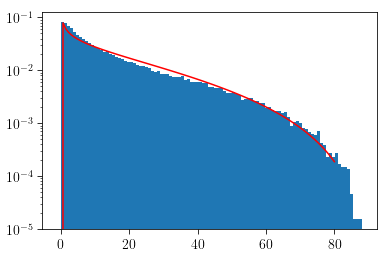

In [16]:
mean = scipy.stats.distributions.beta.fit(disAngle,)

x = np.linspace(-1,80,100)

fitted_data = scipy.stats.distributions.beta.pdf(x,mean[0], mean[1], mean[2],mean[3])

plt.hist(disAngle, density=True, bins=100)
plt.plot(x,fitted_data,'r-')
plt.yscale('log')

In [17]:
scipy.stats.beta.stats(mean[0],mean[1],moments='mvsk')

(array(0.18297908), array(0.03073615), array(1.23349156), array(1.0756138))